In [1]:
!pip install tensorflow tensorflow-federated

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of tensorflow-federated to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 114.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
INFO: pip is looking at multiple versions of grpcio-tools to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple ver

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/Data.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data/client3/nutrition_deficiency_1/dr_43_4193.jpg  
  inflating: __MACOSX/Data/client3/nutrition_deficiency_1/._dr_43_4193.jpg  
  inflating: Data/client3/nutrition_deficiency_1/89_4.jpg  
  inflating: __MACOSX/Data/client3/nutrition_deficiency_1/._89_4.jpg  
  inflating: Data/client3/nutrition_deficiency_1/aug_239_dr_132_8580.jpg  
  inflating: __MACOSX/Data/client3/nutrition_deficiency_1/._aug_239_dr_132_8580.jpg  
  inflating: Data/client3/nutrition_deficiency_1/aug_567_dr_104_3591.jpg  
  inflating: __MACOSX/Data/client3/nutrition_deficiency_1/._aug_567_dr_104_3591.jpg  
  inflating: Data/client3/nutrition_deficiency_1/dr_129_9345.jpg  
  inflating: __MACOSX/Data/client3/nutrition_deficiency_1/._dr_129_9345.jpg  
  inflating: Data/client3/nutrition_deficiency_1/aug_486_dr_50_1372.jpg  
  inflating: __MACOSX/Data/client3/nutrition_deficiency_1/._aug_486_dr_50_1372.jpg  
  inflating: Data/client3/nutrition_deficiency_1/

In [2]:
data_dir = '/content/Data'  # Update this to your extracted folder path
diseases = ['early_leaf_spot_1', 'late_leaf_spot_1', 'rust_1', 'nutrition_deficiency_1']


In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
import numpy as np
import os

def preprocess_data(client_path, test_size=0.2, random_state=42):
    images = []
    labels = []

    for disease in diseases:
        disease_dir = os.path.join(client_path, disease)
        for img_name in os.listdir(disease_dir):
            img_path = os.path.join(disease_dir, img_name)
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            images.append(img_array)
            labels.append(diseases.index(disease))

    images = np.array(images) / 255.0
    labels = to_categorical(labels, num_classes=len(diseases))

    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=random_state, stratify=labels.argmax(axis=1))
    return x_train, x_test, y_train, y_test


In [4]:
#@title preprocess each client

x1_train, x1_test, y1_train, y1_test = preprocess_data('/content/Data/client1')
x2_train, x2_test, y2_train, y2_test = preprocess_data('/content/Data/client2')
x3_train, x3_test, y3_train, y3_test = preprocess_data('/content/Data/client3')

In [8]:
#@title Client Base Model

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

def create_mobilenet_model():
    base_model = MobileNetV2(input_shape=(224, 224, 3),
                              include_top=False,
                              weights='imagenet')
    base_model.trainable = False  # Freeze the base

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(len(diseases), activation='softmax')  # 4 output classes
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
#@title Train Each Client & Save Weights
def train_and_save_client_model(x_train, y_train, client_name):
    model = create_mobilenet_model()
    history = model.fit(
        x_train, y_train,
        epochs=15,
        batch_size=32,
        verbose=1,
        validation_split=0.2  # Optional: gives val accuracy/loss
    )
    model.save_weights(f'/content/drive/MyDrive/mobilenet_weights/{client_name}_weights.h5')
    return model, history


Run for each client

In [ ]:
# print("training client_1 model")
# client1_model, history1 = train_and_save_client_model(x1_train, y1_train, 'client1')
# print("training client_2 model")
# client2_model, history2 = train_and_save_client_model(x2_train, y2_train, 'client2')
print("training client_3 model")
client3_model, history3 = train_and_save_client_model(x3_train, y3_train, 'client3')

training client_3 model
Epoch 1/15
80/80 [==============================] - 168s 2s/step - loss: 0.5687 - accuracy: 0.7672 - val_loss: 0.3924 - val_accuracy: 0.8401
Epoch 2/15
80/80 [==============================] - 160s 2s/step - loss: 0.2971 - accuracy: 0.8816 - val_loss: 0.3193 - val_accuracy: 0.8668
Epoch 3/15
80/80 [==============================] - 158s 2s/step - loss: 0.2342 - accuracy: 0.9094 - val_loss: 0.2837 - val_accuracy: 0.8903
Epoch 4/15
80/80 [==============================] - 154s 2s/step - loss: 0.1644 - accuracy: 0.9436 - val_loss: 0.2974 - val_accuracy: 0.8903
Epoch 5/15
80/80 [==============================] - 160s 2s/step - loss: 0.1325 - accuracy: 0.9596 - val_loss: 0.2849 - val_accuracy: 0.8903
Epoch 6/15
80/80 [==============================] - 158s 2s/step - loss: 0.1121 - accuracy: 0.9655 - val_loss: 0.3226 - val_accuracy: 0.8589
Epoch 7/15
80/80 [==============================] - 156s 2s/step - loss: 0.0901 - accuracy: 0.9714 - val_loss: 0.2758 - val_accura

In [ ]:
#@title Plot the graphs

import matplotlib.pyplot as plt

def plot_history(history, client_name):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history.get('val_accuracy', []), label='Val Acc')
    plt.title(f'{client_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history.get('val_loss', []), label='Val Loss')
    plt.title(f'{client_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

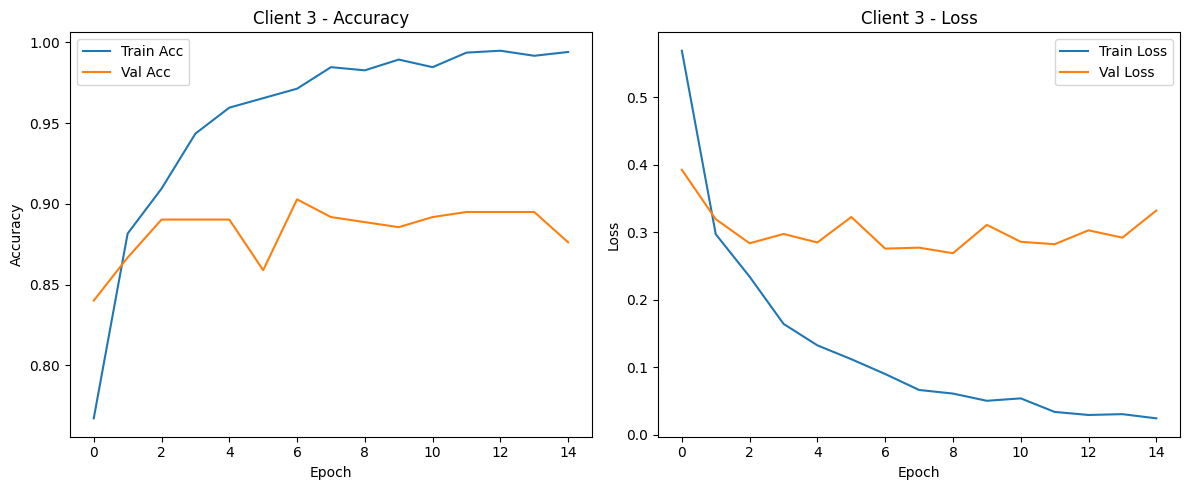

In [ ]:
# plot_history(history1, 'Client 1')
# plot_history(history2, 'Client 2')
plot_history(history3, 'Client 3')

In [5]:
#@title Global Codes

def load_model_weights(file_path):
    model = create_mobilenet_model()
    model.load_weights(file_path)
    return model.get_weights()

In [6]:
def average_weights(weight_list):
    avg_weights = []
    for weights in zip(*weight_list):
        avg_weights.append(np.mean(weights, axis=0))
    return avg_weights

In [9]:
client1_weights = load_model_weights('/content/drive/MyDrive/mobilenet_weights/client1_weights.h5')
client2_weights = load_model_weights('/content/drive/MyDrive/mobilenet_weights/client2_weights.h5')
client3_weights = load_model_weights('/content/drive/MyDrive/mobilenet_weights/client3_weights.h5')

averaged_weights = average_weights([client1_weights, client2_weights, client3_weights])

# Create global model and set averaged weights
global_model = create_mobilenet_model()
global_model.set_weights(averaged_weights)

9406464/9406464 [==============================] - 0s 0us/step


Global Model Evaluating

In [10]:
# Optionally combine data for evaluation
x_test_all = np.concatenate([x1_test, x2_test, x3_test])
y_test_all = np.concatenate([y1_test, y2_test, y3_test])

# Evaluate the global model
loss, accuracy = global_model.evaluate(x_test_all, y_test_all, verbose=1)
print(f" Global Model Accuracy: {accuracy * 100:.2f}%")
print(f" Global Model Loss: {loss:.4f}")

76/76 [==============================] - 127s 2s/step - loss: 0.4439 - accuracy: 0.8315
 Global Model Accuracy: 83.15%
 Global Model Loss: 0.4439
